<a href="https://colab.research.google.com/github/zeligism/CubicOneShotSGD/blob/main/CubicOneShotSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data as data_utils
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

### Download datasets

In [2]:
%%bash
# Download some regression datasets
DATASETS=("abalone" "bodyfat" "cpusmall" "housing" "mg" "mpg" "space_ga")
BASE_LINK="https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression"
for dataset in "${DATASETS[@]}"
    do [[ ! -f "${dataset}" ]] && wget -O "${dataset}" "${BASE_LINK}/${dataset}_scale"
done

In [3]:
DATASET_FEATURES = {
    "abalone": 8,
    "bodyfat": 14,
    "cpusmall": 12,
    "housing": 13,
    "mg": 6,
    "mpg": 7,
    "space_ga": 6,
}

## Args

In [20]:
# Easy to transfer to code using argparse
class Args:
    def __init__(self):
        self.random_seed = 1
        self.dataset = "space_ga"
        self.feature_dim = DATASET_FEATURES[self.dataset]
        self.output_dim = 1
        self.device = "cuda:0"

        self.num_models = 10
        self.T = 100
        self.base_lr = 5e-2
        self.lrs = [self.base_lr] * self.num_models
        self.batch_size = 1

        self.agg_shots = 1
        self.track_model = "random"
        self.val_freq = 1  # per 'num_models' grad computation

args = Args()

In [21]:
!echo "{args.dataset}:" && head "{args.dataset}"

space_ga:
-0.661559 1:0.00592061 2:-0.00797148 3:0.0708837 4:-0.121748 5:0.327746 6:-0.373847 
-0.650859 1:0.172948 2:0.164467 3:0.246374 4:0.0562393 5:0.288422 6:-0.533003 
-0.617114 1:-0.0390871 2:-0.095127 3:0.0167962 4:-0.219127 5:0.371988 6:-0.431117 
-0.63907 1:-0.119603 2:-0.196017 3:-0.0617125 4:-0.293841 5:0.310601 6:-0.335499 
-0.700274 1:0.0379821 2:-0.0147899 3:0.114062 4:-0.11785 5:0.330404 6:-0.252621 
-0.226367 1:-0.193244 2:-0.265719 3:-0.143932 4:-0.409506 5:0.360374 6:-0.410988 
-0.573181 1:-0.0600645 2:-0.114375 3:-0.00680918 4:-0.242633 5:0.326304 6:-0.440485 
-0.879874 1:0.254623 2:0.217428 3:0.293267 4:0.125499 5:0.356565 6:-0.269925 
-0.832006 1:0.0495964 2:-0.00583452 3:0.110378 4:-0.105459 5:0.371959 6:-0.342394 
-0.732962 1:-0.0784499 2:-0.142134 3:-0.0156008 4:-0.238071 5:0.364331 6:-0.235136 


## Dataset

In [22]:
from sklearn.datasets import load_svmlight_file

class MyDataset(data_utils.Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        with open(self.dataset, "rb") as f:
            self.X, self.y = load_svmlight_file(f)

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        X_tensor = torch.Tensor(self.X[idx].todense()).squeeze(0)
        y_tensor = torch.Tensor([self.y[idx]]).squeeze(0)
        return X_tensor, y_tensor

class DataSampler:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.reset_sampler()

    def reset_sampler(self):
        self.sampler = iter(self.dataloader)

    def sample(self):
        try:
            x, y = next(self.sampler)
        except StopIteration:
            self.reset_sampler()
            x, y = next(self.sampler)
        return x, y

## Optimizer

In [23]:
class LocalSGD(torch.optim.SGD):
    def aggregate_and_sync(self):
        agg_params = self.aggregate(self.param_groups)
        # Synchronize
        num_params = len(param_groups[0]["params"])
        for model_idx in range(len(param_groups)):
            for param_idx in range(num_params):
                self.param_groups[model_idx]["params"][param_idx] = agg_params[param_idx]

    def aggregate(self, param_groups=None):
        if param_groups is None:
            param_groups = self.param_groups
        # This function simply averages parameters across all groups/models
        num_params = len(param_groups[0]["params"])
        agg_params = [None] * num_params
        # Find average per parameter
        for param_idx in range(num_params):
            param_list = [param_groups[model_idx]["params"][param_idx].data
                          for model_idx in range(len(param_groups))]
            agg_params[param_idx] = torch.mean(torch.stack(param_list, dim=0), dim=0)

        return agg_params


### Aggregation Schedule

In [24]:
# The schedule is just the iterations in which we aggregate
def n_shot_schedule(N, T):
    return {i for i in range(T-1, 0, -T // N)}

aggregation_idxs = n_shot_schedule(args.agg_shots, args.T)
aggregation_idxs

{99}

## Model

In [25]:
def create_model():
    return nn.Linear(args.feature_dim, args.output_dim)

def init_model_(model):
    def init_weights(m):
        if isinstance(m, nn.Linear):
            # Use default initialization
            pass
    model.apply(init_weights)

def init_like_(m1, m2):
    with torch.no_grad():
        for p1, p2 in zip(m1.parameters(), m2.parameters()):
            p1.copy_(p2)

# Training

Init stuff

In [31]:
def manual_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Set seed if given
if args.random_seed is not None:
    manual_seed(args.random_seed)

# Initialize dataset
#dataset = MyDataset(args.dataset)
#test_len = int(args.test_size * len(dataset))
#trainset, testset = data_utils.random_split(dataset, [len(dataset) - test_len, test_len])
trainset = MyDataset(args.dataset)
testset = MyDataset(args.dataset)  # test on full dataset
trainloader = data_utils.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, pin_memory=True)
testloader = data_utils.DataLoader(testset, batch_size=len(testset), shuffle=False, pin_memory=True)

# Define a group of models (optimized in parallel) and a singled out model (optimized alone)
one_model = create_model().to(device=args.device)
one_optimizer = torch.optim.SGD(one_model.parameters(), lr=args.base_lr)
models = [create_model().to(device=args.device) for i in range(args.num_models)]
param_groups = [{"params": models[i].parameters(), "lr": args.lrs[i]} for i in range(args.num_models)]
optimizer = LocalSGD(param_groups, lr=args.base_lr)
# Create dummy model for evaluating aggregated models
agg_model = create_model().to(device=args.device)
# Use MSE Loss
loss_fn = nn.MSELoss().to(device=args.device)
# Init models
init_model_(one_model)
for model in models:
    init_like_(model, one_model)

In [32]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


In [34]:
def validate(testloader, model):
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0
        for x, y in testloader:
            x = x.to(device=args.device)
            y = y.to(device=args.device)
            y_pred = model(x).view_as(y)
            loss = loss_fn(y_pred, y)
            acc = torch.sum(y_pred.round() == y) / y.size(0)
            running_loss += loss.item()
            running_acc += acc.item()
        mean_loss = running_loss / len(testloader)
        mean_acc = running_acc / len(testloader)
    return mean_loss, mean_acc

def train(T, trainloader, testloader, models, one_model,
          optimizer, one_optimizer, loss_fn,
          aggregation_idxs=[], track_model="random"):
    data_sampler = DataSampler(trainloader)
    stats = defaultdict(list)
    train_losses = AverageMeter("many_train_loss", ":.4f")
    val_losses = AverageMeter("many_val_loss", ":.4f")
    one_train_losses = AverageMeter("one_train_loss", ":.4f")
    one_val_losses = AverageMeter("one_val_loss", ":.4f")
    progress = ProgressMeter(T, [train_losses, val_losses, one_train_losses, one_val_losses])

    for t in range(T):
        # model loop should be run in parallel
        for model in models:
            x, y = data_sampler.sample() # assuming a central dataset
            x = x.to(device=args.device)
            y = y.to(device=args.device)
            # Train each model
            y_pred = model(x).view_as(y)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            stats["many_train_loss"] += [loss.item()]
            train_losses.update(loss.item())
            # Train the singled out model in every step
            y_pred = one_model(x).view_as(y)
            loss = loss_fn(y_pred, y)
            one_optimizer.zero_grad()
            loss.backward()
            one_optimizer.step()
            stats["one_train_loss"] += [loss.item()]
            one_train_losses.update(loss.item())
        # Aggregate the gradient steps by averaging the parameters
        if t in aggregation_idxs:
            print("Aggregating parameters...")
            optimizer.aggregate_and_sync()

        # Validate aggregate model on full dataset
        if t % args.val_freq == 0:
            with torch.no_grad():
                agg_params = optimizer.aggregate()
                for p1, p2 in zip(agg_model.parameters(), agg_params):
                    p1.copy_(p2)
            val_loss, _ = validate(testloader, agg_model)
            one_val_loss, _ = validate(testloader, one_model)
            stats[f"many_val_loss"] += [val_loss]
            stats["one_val_loss"] += [one_val_loss]
            val_losses.update(val_loss)
            one_val_losses.update(one_val_loss)
        progress.display(t)
    
    return stats

stats_ = train(args.T, trainloader, testloader,
              models, one_model, optimizer, one_optimizer, loss_fn,
              aggregation_idxs, track_model=args.track_model)

[  0/100]	many_train_loss 0.2291 (0.2747)	many_val_loss 0.1822 (0.1822)	one_train_loss 0.0472 (0.1558)	one_val_loss 0.0505 (0.0505)
[  1/100]	many_train_loss 0.0462 (0.1887)	many_val_loss 0.1612 (0.1717)	one_train_loss 0.0015 (0.0916)	one_val_loss 0.0484 (0.0494)
[  2/100]	many_train_loss 0.0651 (0.2281)	many_val_loss 0.1343 (0.1592)	one_train_loss 0.0093 (0.1134)	one_val_loss 0.0356 (0.0448)
[  3/100]	many_train_loss 0.0426 (0.2030)	many_val_loss 0.1148 (0.1481)	one_train_loss 0.0411 (0.0897)	one_val_loss 0.0350 (0.0424)
[  4/100]	many_train_loss 0.1867 (0.1928)	many_val_loss 0.0970 (0.1379)	one_train_loss 0.0003 (0.0759)	one_val_loss 0.0355 (0.0410)
[  5/100]	many_train_loss 0.0256 (0.1747)	many_val_loss 0.0880 (0.1296)	one_train_loss 0.0079 (0.0706)	one_val_loss 0.0301 (0.0392)
[  6/100]	many_train_loss 0.0080 (0.1667)	many_val_loss 0.0797 (0.1225)	one_train_loss 0.0339 (0.0662)	one_val_loss 0.0279 (0.0376)
[  7/100]	many_train_loss 0.1726 (0.1536)	many_val_loss 0.0745 (0.1165)	one_

### Separate functions for training multiple models vs. single model

In [29]:
def train_model(T, trainloader, testloader, model, optimizer, loss_fn):
    data_sampler = DataSampler(trainloader)
    stats = defaultdict(list)
    train_losses = AverageMeter("train_loss", ":.4f")
    val_losses = AverageMeter("val_loss", ":.4f")
    progress = ProgressMeter(T, [train_losses, val_losses])

    for t in range(T):
        x, y = data_sampler.sample()
        x = x.to(device=args.device)
        y = y.to(device=args.device)
        y_pred = model(x).view_as(y)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stats["train_loss"] += [loss.item()]
        train_losses.update(loss.item())

        # Validate aggregate model on full dataset
        if t % (args.val_freq * args.num_models) == 0:
            val_loss, _ = validate(testloader, model)
            stats["val_loss"] += [val_loss]
            val_losses.update(val_loss)
        
        progress.display(t)
    
    return stats


def train_models(T, trainloader, testloader, models, optimizer, loss_fn):
    data_sampler = DataSampler(trainloader)
    stats = defaultdict(list)
    train_losses = AverageMeter("train_loss", ":.4f")
    val_losses = AverageMeter("val_loss", ":.4f")
    progress = ProgressMeter(T, [train_losses, val_losses])

    for t in range(T):
        for model in models:
            x, y = data_sampler.sample()
            x = x.to(device=args.device)
            y = y.to(device=args.device)
            y_pred = model(x).view_as(y)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            stats["train_loss"] += [loss.item()]
            train_losses.update(loss.item())

        if t % args.val_freq == 0:
            with torch.no_grad():
                agg_params = optimizer.aggregate()
                for p1, p2 in zip(agg_model.parameters(), agg_params):
                    p1.copy_(p2)
            val_loss, _ = validate(testloader, agg_model)
            stats["val_loss"] += [val_loss]
            val_losses.update(val_loss)
        
        progress.display(t)
    
    return stats

print("Training single model...")
stats_model = train_model(args.T*args.num_models, trainloader, testloader, one_model, one_optimizer, loss_fn)
print("Training multiple models...")
stats_models = train_models(args.T, trainloader, testloader, models, optimizer, loss_fn)

stats = {
    "many_train_loss": stats_models["train_loss"],
    "many_val_loss": stats_models["val_loss"],
    "one_train_loss": stats_model["train_loss"],
    "one_val_loss": stats_model["val_loss"],
}

Training single model...
[   0/1000]	train_loss 0.1183 (0.1183)	val_loss 0.1963 (0.1963)
[   1/1000]	train_loss 0.4413 (0.2798)	val_loss 0.1963 (0.1963)
[   2/1000]	train_loss 0.0547 (0.2048)	val_loss 0.1963 (0.1963)
[   3/1000]	train_loss 0.4906 (0.2762)	val_loss 0.1963 (0.1963)
[   4/1000]	train_loss 0.1514 (0.2513)	val_loss 0.1963 (0.1963)
[   5/1000]	train_loss 0.0423 (0.2164)	val_loss 0.1963 (0.1963)
[   6/1000]	train_loss 0.0158 (0.1878)	val_loss 0.1963 (0.1963)
[   7/1000]	train_loss 0.1050 (0.1774)	val_loss 0.1963 (0.1963)
[   8/1000]	train_loss 0.1366 (0.1729)	val_loss 0.1963 (0.1963)
[   9/1000]	train_loss 0.0898 (0.1646)	val_loss 0.1963 (0.1963)
[  10/1000]	train_loss 0.0594 (0.1550)	val_loss 0.0466 (0.1214)
[  11/1000]	train_loss 0.3092 (0.1679)	val_loss 0.0466 (0.1214)
[  12/1000]	train_loss 0.0135 (0.1560)	val_loss 0.0466 (0.1214)
[  13/1000]	train_loss 0.1622 (0.1564)	val_loss 0.0466 (0.1214)
[  14/1000]	train_loss 0.0561 (0.1497)	val_loss 0.0466 (0.1214)
[  15/1000]	tra

# Results

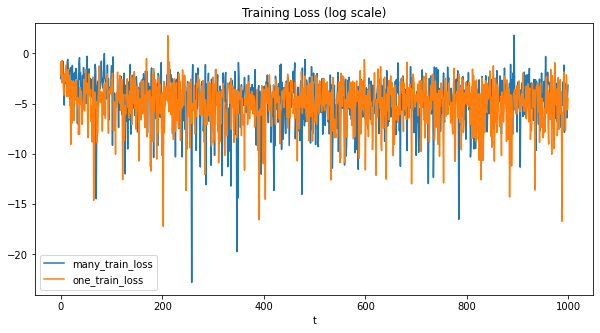

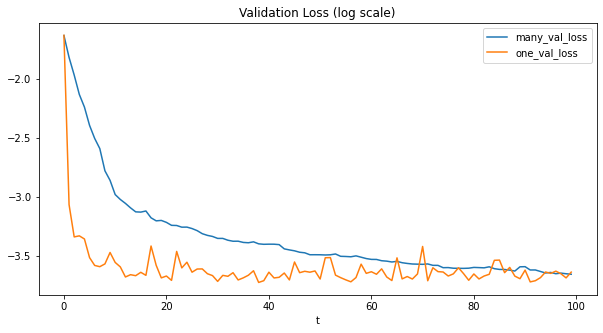

In [37]:
from math import log
log_scale = True

def plot_lines(losses_dict, title="", filename=None, ):
    plt.figure(figsize=(10,5))
    plt.title(title)
    for label, losses in losses_dict.items():
        plt.plot(losses, label=label)
    plt.xlabel("t")
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    plt.close()

apply_log = lambda v: list(map(log, v))
train_losses = {k: apply_log(v) if log_scale else v for k, v in stats.items() if "train_loss" in k}
val_losses = {k: apply_log(v) if log_scale else v for k, v in stats.items() if "val_loss" in k}
accuracies = {k: v for k, v in stats.items() if "acc" in k}
plot_lines(train_losses, "Training Loss" + (" (log scale)" if log_scale else ""))
plot_lines(val_losses, "Validation Loss" + (" (log scale)" if log_scale else ""))
#plot_lines(accuracies, "Accuracy")

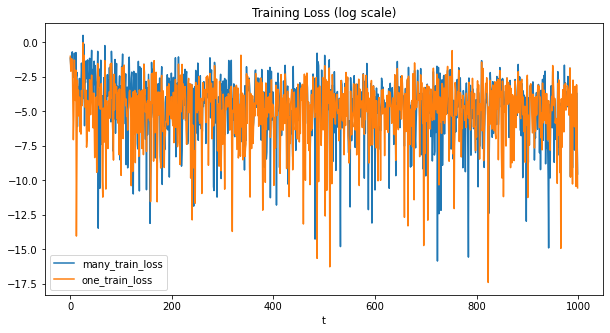

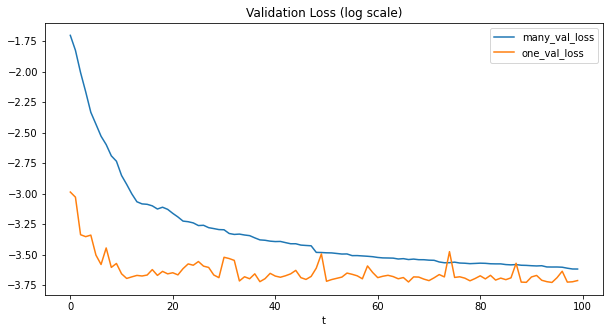

In [35]:
from math import log
log_scale = True

def plot_lines(losses_dict, title="", filename=None, ):
    plt.figure(figsize=(10,5))
    plt.title(title)
    for label, losses in losses_dict.items():
        plt.plot(losses, label=label)
    plt.xlabel("t")
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    plt.close()

apply_log = lambda v: list(map(log, v))
train_losses = {k: apply_log(v) if log_scale else v for k, v in stats_.items() if "train_loss" in k}
val_losses = {k: apply_log(v) if log_scale else v for k, v in stats_.items() if "val_loss" in k}
plot_lines(train_losses, "Training Loss" + (" (log scale)" if log_scale else ""))
plot_lines(val_losses, "Validation Loss" + (" (log scale)" if log_scale else ""))